# **Neuropolis-X1**
### **Building an artificial intelligence system for human brain activity prediction (EEG, fMRI) with machine learning, deep learning, and large language models**

#### Maël Donoso, Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/)
First release: *18th March 2025*

This first extension (X1) of Neuropolis includes fourteen Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Classification Models*

*04: Regression Models*

***05: Neural Networks***

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

*08: Transformers*

*09: Large Language Models*

*10: Large Language Model Chain-of-Thought*

*11: Large Language Model Fine-Tuning*

*12: Large Multimodal Model*

*13: Statistical Tests*

*14: Tables and Figures*

### Notebook 05

# **Neural Networks**

## **1. Classification**

We define a **feedforward neural network model** for a classification task, using the **Adam optimizer** and the **binary cross-entropy loss function**. Our objective is to predict whether the fMRI signal increases or decreases in our brain regions of interest. We run the model on all subjects, except sub-xp102 who has a missing condition, and use the eegfmriNF condition as the train set, the eegNF condition as the validation set, and the fmriNF condition as the test set. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import os
import logging

In [2]:
# Define the raw data path. 
raw_data_path = '../../Neuropolis/ds002336-download/'

# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis-x1_preprocessed_data/'

# Define the results path. 
results_path = '../neuropolis-x1_results/'

In [3]:
# Load the features, the targets, and the baseline for the classification task. 
with open(preprocessed_data_path + 'dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_features_classification_sequence.p', 'rb') as file:
    dict_features_sequence_class = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_targets_classification_sequence.p', 'rb') as file:
    dict_targets_sequence_class = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_baseline_classification_sequence.p', 'rb') as file:
    dict_baseline_sequence_class = pickle.load(file)

In [4]:
# Define the list of subjects, removing sub-xp102 who has a missing condition. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subjects.remove('sub-xp102')
subject = subjects[0]

# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())

# Select a sequence length. 
selected_sequence_length = 5

# Retrieve the total number of scans. 
nb_scans_total = dict_targets[subject]['eegfmriNF']['Frontal Pole'].shape[0]

# Define the batch size for the neural networks models. 
batch_size = 32

# Define a dictionary to store the FLOPS for each model. 
dict_flops = dict()

In [5]:
# Define a function to run a neural network model for a classification task. 
def run_neural_network_classification(NeuralNetworkModel, dict_features_sequence, dict_targets_sequence, dict_baseline_sequence):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorBrain = tf.keras.models.clone_model(NeuralNetworkModel)

        # Retrieve the features of the train set, validation set, and test set. 
        X_tr = dict_features_sequence[subject]['eegfmriNF']
        X_va = dict_features_sequence[subject]['eegNF']
        X_te = dict_features_sequence[subject]['fmriNF']

        # Retrieve the targets of the train set, validation set, and test set. 
        Y_tr = dict_targets_sequence[subject]['eegfmriNF']
        Y_va = dict_targets_sequence[subject]['eegNF']
        Y_te = dict_targets_sequence[subject]['fmriNF']

        # Retrieve the baseline of the train set and determine the baseline accuracy. 
        Baseline = dict_baseline_sequence[subject]['eegfmriNF']
        accuracy_baseline = np.mean(Baseline == Y_te)

        # Rescale features variables. 
        scaler = StandardScaler()
        X_tr_standardized = scaler.fit_transform(X_tr)
        X_va_standardized = scaler.transform(X_va)
        X_te_standardized = scaler.transform(X_te)

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6, 
                                                          restore_best_weights = True)

        # Define the loss function, optimizer, and metrics to track during training. 
        PredictorBrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                               loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

        # Fit the model. 
        NeuralNetworkHistory = PredictorBrain.fit(
            x = X_tr_standardized, y = Y_tr,
            validation_data = (X_va_standardized, Y_va), 
            batch_size = batch_size, epochs = 50,
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Evaluate the test accuracy. 
        (loss_test, accuracy_test) = PredictorBrain.evaluate(X_te_standardized, Y_te, batch_size = batch_size)
        print(f'test loss: {loss_test:.4f}, test accuracy: {accuracy_test:.4f}')

        # Compute the predictions from the neural network. 
        Y_pred = PredictorBrain.predict(X_te_standardized)

        # Convert the probabilities to binary predictions. 
        Y_pred_binary = (Y_pred > 0.5).astype(int)

        # Store the performance metrics and the shapes of the arrays in the DataFrame. 
        df_summary.loc[subject, 'loss_train'] = NeuralNetworkHistory.history['loss'][-1]
        df_summary.loc[subject, 'loss_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
        df_summary.loc[subject, 'loss_test'] = loss_test
        df_summary.loc[subject, 'accuracy_train'] = NeuralNetworkHistory.history['binary_accuracy'][-1]
        df_summary.loc[subject, 'accuracy_valid'] = NeuralNetworkHistory.history['val_binary_accuracy'][-1]
        df_summary.loc[subject, 'accuracy_test'] = accuracy_test
        df_summary.loc[subject, 'accuracy_baseline'] = accuracy_baseline
        df_summary.loc[subject, 'above_baseline'] = str(accuracy_test > accuracy_baseline)
        df_summary.loc[subject, 'X_tr.shape'] = str(X_tr_standardized.shape)
        df_summary.loc[subject, 'X_va.shape'] = str(X_va_standardized.shape)
        df_summary.loc[subject, 'X_te.shape'] = str(X_te_standardized.shape)
        df_summary.loc[subject, 'Y_tr.shape'] = str(Y_tr.shape)
        df_summary.loc[subject, 'Y_va.shape'] = str(Y_va.shape)
        df_summary.loc[subject, 'Y_te.shape'] = str(Y_te.shape)

        # Store the trained model, the model history, and the predictions in the dictionary. 
        dict_models[subject] = PredictorBrain
        dict_history[subject] = NeuralNetworkHistory
        dict_predictions[subject] = Y_pred_binary
    
    return dict_models, dict_history, dict_predictions, df_summary

In [6]:
# Define a function to plot the results of the neural network training. 
def plot_neural_network_classification(dict_history_class, title):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 52))
    fig.suptitle(title, fontsize = 14, y = 0.895)
    subject_index = 0

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the history. 
        NeuralNetworkHistory = dict_history_class[subject]

        # Plot loss values. 
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['loss'], label = 'train loss', color = 'blue')
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['val_loss'], label = 'val loss', color = 'green')
        axes[subject_index, 0].set_title(str(subject) + ' valid. loss: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_loss'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 0].set_xlabel('Epoch')
        axes[subject_index, 0].set_ylabel('Loss value')
        axes[subject_index, 0].legend()

        # Plot accuracy values. 
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['binary_accuracy'], label = 'train acc', color = 'blue')
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['val_binary_accuracy'], label = 'val acc', color = 'green')
        axes[subject_index, 1].set_title(str(subject) + ' valid. accuracy: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_binary_accuracy'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 1].set_xlabel('Epoch')
        axes[subject_index, 1].set_ylabel('Accuracy')
        axes[subject_index, 1].legend();

        # Increment. 
        subject_index += 1

In [7]:
# Define the neural network model. 
tf.random.set_seed(0)
NeuralNetworkModel = tf.keras.Sequential()
input_dim = dict_features_sequence_class[subject]['eegfmriNF'].shape[1]

# Input layer. 
NeuralNetworkModel.add(tf.keras.layers.InputLayer(shape = (input_dim, )))

# Dense layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 4096, activation = tf.keras.activations.relu, 
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = tf.keras.regularizers.l2(0.01), bias_regularizer = tf.keras.regularizers.l2(0.01)
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5))

# Dense layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 512, activation = tf.keras.activations.relu, 
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = tf.keras.regularizers.l2(0.01), bias_regularizer = tf.keras.regularizers.l2(0.01)
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5))

# Output layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = len(targets), activation = tf.keras.activations.sigmoid,
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Print network summary. 
NeuralNetworkModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096)           │     9,293,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 49)             │        25,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,416,625 (43.55 MB)

 Trainable params: 11,416,625 (43.55 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Run the neural network model. 
dict_models_class, dict_history_class, dict_predictions_class, df_summary_class = run_neural_network_classification(NeuralNetworkModel, 
                                                                                                                    dict_features_sequence_class, 
                                                                                                                    dict_targets_sequence_class, 
                                                                                                                    dict_baseline_sequence_class)

sub-xp101
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5053 - loss: 1.0590 
test loss: 1.0555, test accuracy: 0.5145
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-xp103
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5576 - loss: 0.9372 
test loss: 0.9319, test accuracy: 0.5621
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-xp104
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5378 - loss: 1.0366 
test loss: 1.0447, test accuracy: 0.5311
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-xp105
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5393 - loss: 1.1326 
test loss: 1.1851, test accuracy: 0.5321
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-xp106
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5355 - loss: 1.0221 
test loss: 1.0150, test accuracy: 0.5398
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-xp107
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5591 - loss: 0.9377 
test loss: 0.9392, test accuracy: 0.5542
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

In [9]:
# Display the results. 
print('Neural Networks: Classification')
df_summary_class

Neural Networks: Classification


,loss_train,loss_valid,loss_test,accuracy_train,accuracy_valid,accuracy_test,accuracy_baseline,above_baseline,X_tr.shape,X_va.shape,X_te.shape,Y_tr.shape,Y_va.shape,Y_te.shape
sub-xp101,0.942784,1.176277,1.055460,0.655586,0.517252,0.514517,0.480328,True,"(194, 2268)","(194, 2268)","(194, 2268)","(194, 49)","(194, 49)","(194, 49)"
sub-xp103,0.837204,1.001244,0.931893,0.720072,0.534294,0.562066,0.507995,True,"(194, 2268)","(194, 2268)","(194, 2268)","(194, 49)","(194, 49)","(194, 49)"
sub-xp104,0.853508,1.061264,1.044746,0.738586,0.519251,0.531138,0.498948,True,"(194, 2268)","(194, 2268)","(194, 2268)","(194, 49)","(194, 49)","(194, 49)"
sub-xp105,0.795778,1.046182,1.185092,0.745214,0.531875,0.532085,0.499158,True,"(194, 2268)","(194, 2268)","(194, 2268)","(194, 49)","(194, 49)","(194, 49)"
sub-xp106,0.843043,1.041055,1.015048,0.730170,0.504839,0.539764,0.494004,True,"(194, 2268)","(194, 2268)","(194, 2268)","(194, 49)","(194, 49)","(194, 49)"
sub-xp107,0.764724,0.985975,0.939221,0.738165,0.539028,0.554176,0.505049,True,"(194, 2268)","(194, 2268)","(194, 2268)","(194, 49)","(194, 49)","(194, 49)"
sub-xp108,0.903338,1.114447,0.932496,0.681464,0.506312,0.557753,0.500000,True,"(194, 2268)","(194, 2268)","(194, 2268)","(194, 49)","(194, 49)","(194, 49)"
sub-xp109,0.840031,0.978661,0.994173,0.697770,0.530928,0.499369,0.499369,False,"(194, 2268)","(194, 2268)","(194, 2268)","(194, 49)","(194, 49)","(194, 49)"
sub-xp110,0.811381,1.111014,1.026045,0.791500,0.510204,0.535241,0.504523,True,"(194, 2268)","(194, 2268)","(194, 2268)","(194, 49)","(194, 49)","(194, 49)"


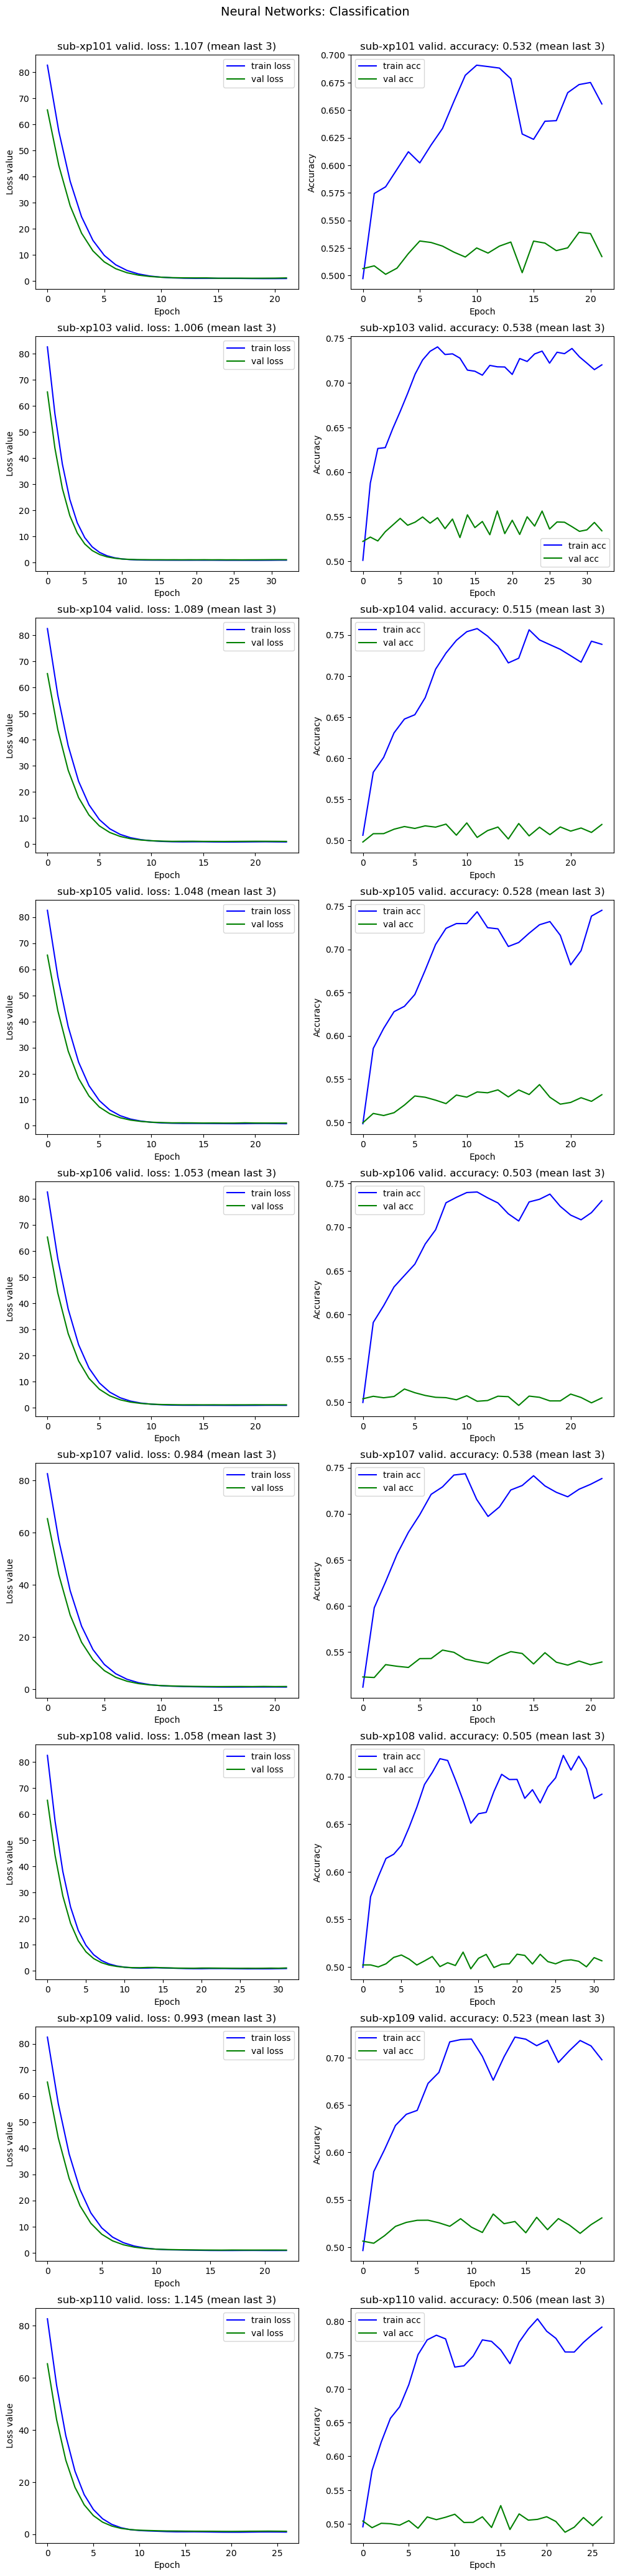

In [10]:
# Display the results. 
plot_neural_network_classification(dict_history_class, title = 'Neural Networks: Classification')

In [11]:
# Define a function to measure the FLOPs of a model. 
def get_flops(model, input_shape):

    # Retrieve the graph of the concrete function. 
    concrete_func = tf.function(model).get_concrete_function(tf.TensorSpec(input_shape, tf.float32))
    graph = concrete_func.graph

    # Measure the FLOPs. 
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph = graph,
                                          run_meta = run_meta,
                                          cmd = 'op',
                                          options = opts)

    return flops.total_float_ops

In [12]:
# Suppress TensorFlow warnings. 
tf.get_logger().setLevel(logging.ERROR)

# Measure the FLOPs of the model. 
input_shape = (1, input_dim)  # Batch size = 1. 
flops = get_flops(NeuralNetworkModel, input_shape)


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [13]:
# Store and display the number of FLOPs. 
dict_flops['Neural Networks: Classification'] = flops
print('FLOPs per inference:', flops)

FLOPs per inference: 22828593


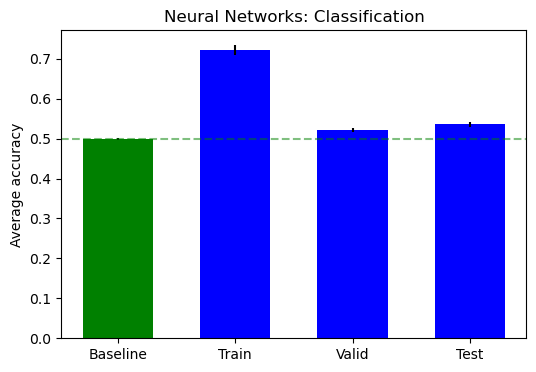

In [14]:
# Retrieve the average accuracy and the standard error of the accuracy. 
acc = [df_summary_class['accuracy_baseline'].mean(), 
       df_summary_class['accuracy_train'].mean(), 
       df_summary_class['accuracy_valid'].mean(), 
       df_summary_class['accuracy_test'].mean()]
acc_se = [np.std(df_summary_class['accuracy_baseline']) / np.sqrt(df_summary_class['accuracy_baseline'].shape[0]), 
          np.std(df_summary_class['accuracy_train']) / np.sqrt(df_summary_class['accuracy_train'].shape[0]), 
          np.std(df_summary_class['accuracy_valid']) / np.sqrt(df_summary_class['accuracy_valid'].shape[0]), 
          np.std(df_summary_class['accuracy_test']) / np.sqrt(df_summary_class['accuracy_test'].shape[0])]

# Display the average accuracy and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), acc, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), acc, yerr = acc_se, fmt = 'None', color = 'black')
axes.axhline(acc[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average accuracy')
axes.set_title('Neural Networks: Classification');

## **2. Regression**

We define a **feedforward neural network model** for a regression task, using the **Adam optimizer** and the **mean squared error loss function**. Our objective is to predict the value of the fMRI signal in our brain regions of interest. We run the model on all subjects, except sub-xp102 who has a missing condition, and use the eegfmriNF condition as the train set, the eegNF condition as the validation set, and the fmriNF condition as the test set. 

In [15]:
# Load the features, the targets, and the baseline for the regression task. 
with open(preprocessed_data_path + 'regression/dict_features_regression_sequence.p', 'rb') as file:
    dict_features_sequence_reg = pickle.load(file)
with open(preprocessed_data_path + 'regression/dict_targets_regression_sequence.p', 'rb') as file:
    dict_targets_sequence_reg = pickle.load(file)
with open(preprocessed_data_path + 'regression/dict_baseline_regression_sequence.p', 'rb') as file:
    dict_baseline_sequence_reg = pickle.load(file)

In [16]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [17]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [18]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [19]:
# Define a function to run a neural network model for a regression task. 
def run_neural_network_regression(NeuralNetworkModel, dict_features_sequence, dict_targets_sequence, dict_baseline_sequence):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorBrain = tf.keras.models.clone_model(NeuralNetworkModel)

        # Retrieve the features of the train set, validation set, and test set. 
        X_tr = dict_features_sequence[subject]['eegfmriNF']
        X_va = dict_features_sequence[subject]['eegNF']
        X_te = dict_features_sequence[subject]['fmriNF']

        # Retrieve the targets of the train set, validation set, and test set. 
        Y_tr = dict_targets_sequence[subject]['eegfmriNF']
        Y_va = dict_targets_sequence[subject]['eegNF']
        Y_te = dict_targets_sequence[subject]['fmriNF']

        # Retrieve the baseline of the train set. 
        Baseline = dict_baseline_sequence[subject]['eegfmriNF']

        # Rescale features variables. 
        scaler = StandardScaler()
        X_tr_standardized = scaler.fit_transform(X_tr)
        X_va_standardized = scaler.transform(X_va)
        X_te_standardized = scaler.transform(X_te)

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6, 
                                                          restore_best_weights = True)

        # Define the loss function, optimizer, and metrics to track during training. 
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.9)
        PredictorBrain.compile(optimizer = optimizer, loss = 'mse', metrics = [tf.keras.metrics.MeanAbsoluteError()])

        # Fit the model. 
        NeuralNetworkHistory = PredictorBrain.fit(
            x = X_tr_standardized, y = Y_tr,
            validation_data = (X_va_standardized, Y_va), 
            batch_size = batch_size, epochs = 50, 
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Evaluate the test MSE and MAE. 
        (mse_test, mae_test) = PredictorBrain.evaluate(X_te_standardized, Y_te, batch_size = batch_size)
        print(f'test MSE: {mse_test:.4f}, test MAE: {mae_test:.4f}')

        # Compute the predictions from the neural network. 
        Y_pred = PredictorBrain.predict(X_te_standardized)

        # Evaluate the performance metrics. 
        mse_baseline = MSE(Y_te, Baseline)
        mae_baseline = MAE(Y_te, Baseline)
        rss_baseline = RSS(Y_te, Baseline)
        mse_model = MSE(Y_te, Y_pred)
        mae_model = MAE(Y_te, Y_pred)
        rss_model = RSS(Y_te, Y_pred)
        r2_model = 1 - (rss_model / rss_baseline)

        # Store the performance metrics and the shapes of the arrays in the DataFrame. 
        df_summary.loc[subject, 'mse_train'] = NeuralNetworkHistory.history['loss'][-1]
        df_summary.loc[subject, 'mse_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
        df_summary.loc[subject, 'mse_test'] = mse_test
        df_summary.loc[subject, 'mae_train'] = NeuralNetworkHistory.history['mean_absolute_error'][-1]
        df_summary.loc[subject, 'mae_valid'] = NeuralNetworkHistory.history['val_mean_absolute_error'][-1]
        df_summary.loc[subject, 'mae_test'] = mae_test
        df_summary.loc[subject, 'mae_baseline'] = mae_baseline
        df_summary.loc[subject, 'r2_model'] = r2_model
        df_summary.loc[subject, 'X_tr.shape'] = str(X_tr_standardized.shape)
        df_summary.loc[subject, 'X_va.shape'] = str(X_va_standardized.shape)
        df_summary.loc[subject, 'X_te.shape'] = str(X_te_standardized.shape)
        df_summary.loc[subject, 'Y_tr.shape'] = str(Y_tr.shape)
        df_summary.loc[subject, 'Y_va.shape'] = str(Y_va.shape)
        df_summary.loc[subject, 'Y_te.shape'] = str(Y_te.shape)

        # Store the trained model, the model history, and the predictions in the dictionary. 
        dict_models[subject] = PredictorBrain
        dict_history[subject] = NeuralNetworkHistory
        dict_predictions[subject] = Y_pred
    
    return dict_models, dict_history, dict_predictions, df_summary

In [20]:
# Define a function to plot the results of the neural network training. 
def plot_neural_network_regression(dict_history_reg, title):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 52))
    fig.suptitle(title, fontsize = 14, y = 0.895)
    subject_index = 0

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the history. 
        NeuralNetworkHistory = dict_history_reg[subject]

        # Plot MSE values. 
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['loss'], label = 'train MSE', color = 'blue')
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['val_loss'], label = 'val MSE', color = 'green')
        axes[subject_index, 0].set_title(str(subject) + ' valid. MSE: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_loss'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 0].set_xlabel('Epoch')
        axes[subject_index, 0].set_ylabel('MSE')
        axes[subject_index, 0].legend()

        # Plot MAE values. 
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['mean_absolute_error'], label = 'train MAE', color = 'blue')
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['val_mean_absolute_error'], label = 'val MAE', color = 'green')
        axes[subject_index, 1].set_title(str(subject) + ' valid. MAE: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_mean_absolute_error'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 1].set_xlabel('Epoch')
        axes[subject_index, 1].set_ylabel('MAE')
        axes[subject_index, 1].legend();

        # Increment. 
        subject_index += 1

In [21]:
# Define the neural network model. 
tf.random.set_seed(0)
NeuralNetworkModel = tf.keras.Sequential()
input_dim = dict_features_sequence_reg[subject]['eegfmriNF'].shape[1]

# Input layer. 
NeuralNetworkModel.add(tf.keras.layers.InputLayer(shape = (input_dim, )))

# Dense layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 4096, activation = tf.keras.activations.relu, 
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = tf.keras.regularizers.l2(0.01), bias_regularizer = tf.keras.regularizers.l2(0.01)
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5))

# Dense layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 512, activation = tf.keras.activations.relu, 
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = tf.keras.regularizers.l2(0.01), bias_regularizer = tf.keras.regularizers.l2(0.01)
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5))

# Output layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = dict_targets_sequence_reg[subject]['eegfmriNF'].shape[1], 
    ))

# Print network summary. 
NeuralNetworkModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 4096)           │     9,293,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 49)             │        25,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,416,625 (43.55 MB)

 Trainable params: 11,416,625 (43.55 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Run the neural network model. 
dict_models_reg, dict_history_reg, dict_predictions_reg, df_summary_reg = run_neural_network_regression(NeuralNetworkModel, 
                                                                                                        dict_features_sequence_reg, 
                                                                                                        dict_targets_sequence_reg, 
                                                                                                        dict_baseline_sequence_reg)

sub-xp101
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7337 - mean_absolute_error: 0.7247 
test MSE: 2.7377, test MAE: 0.7201
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-xp103
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1065 - mean_absolute_error: 0.8419 
test MSE: 2.9837, test MAE: 0.7939
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-xp104
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6182 - mean_absolute_error: 0.7615 
test MSE: 2.6069, test MAE: 0.7475
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-xp105
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9640 - mean_absolute_error: 0.8606 
test MSE: 2.8510, test MAE: 0.8114
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-xp106
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1298 - mean_absolute_error: 0.8663 
test MSE: 2.9624, test MAE: 0.7936
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-xp107
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6007 - mean_absolute_error: 0.8281 
test MSE: 3.5531, test MAE: 0.8019
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
sub-

In [23]:
# Display the results. 
print('Neural Networks: Regression')
df_summary_reg

Neural Networks: Regression


,mse_train,mse_valid,mse_test,mae_train,mae_valid,mae_test,mae_baseline,r2_model,X_tr.shape,X_va.shape,X_te.shape,Y_tr.shape,Y_va.shape,Y_te.shape
sub-xp101,5.034870,4.290295,2.737731,0.742843,0.702390,0.720054,0.717371,-0.018109,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 49)","(195, 49)","(195, 49)"
sub-xp103,4.768110,4.232798,2.983701,0.813159,0.770500,0.793915,0.791543,-0.010603,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 49)","(195, 49)","(195, 49)"
sub-xp104,5.733075,4.813182,2.606947,0.697996,0.663098,0.747514,0.754163,0.010553,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 49)","(195, 49)","(195, 49)"
sub-xp105,4.532389,4.337346,2.851026,0.804512,0.796976,0.811418,0.802868,-0.022753,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 49)","(195, 49)","(195, 49)"
sub-xp106,3.787074,3.590701,2.962427,0.777332,0.789970,0.793550,0.783408,-0.045308,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 49)","(195, 49)","(195, 49)"
sub-xp107,5.734308,5.209148,3.553103,0.809624,0.784327,0.801892,0.808135,0.010144,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 49)","(195, 49)","(195, 49)"
sub-xp108,5.655369,7.024496,3.217213,0.807040,0.808114,0.812189,0.817478,0.003273,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 49)","(195, 49)","(195, 49)"
sub-xp109,3.800487,3.870714,3.134733,0.772038,0.818105,0.793655,0.801149,0.004708,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 49)","(195, 49)","(195, 49)"
sub-xp110,3.200492,2.875881,2.801981,0.800971,0.788378,0.821344,0.804844,-0.038461,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 49)","(195, 49)","(195, 49)"


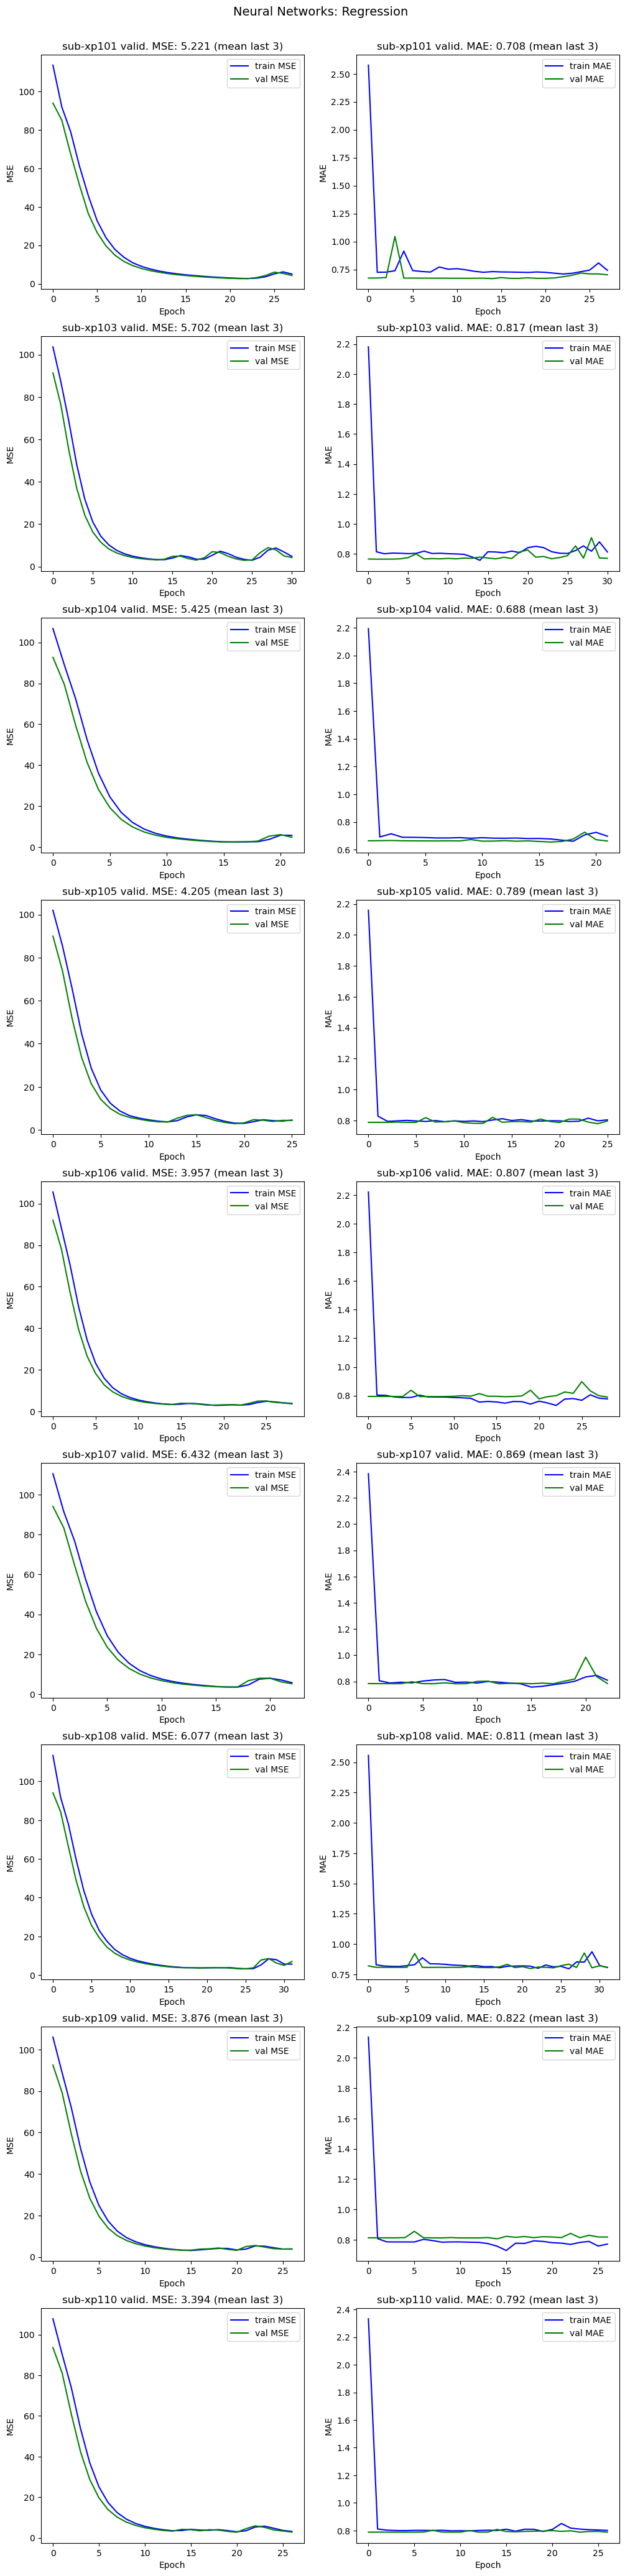

In [24]:
# Display the results. 
plot_neural_network_regression(dict_history_reg, title = 'Neural Networks: Regression')

In [25]:
# Measure the FLOPs of the model. 
input_shape = (1, input_dim)  # Batch size = 1. 
flops = get_flops(NeuralNetworkModel, input_shape)


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [26]:
# Store and display the number of FLOPs. 
dict_flops['Neural Networks: Regression'] = flops
print('FLOPs per inference:', flops)

FLOPs per inference: 22828593


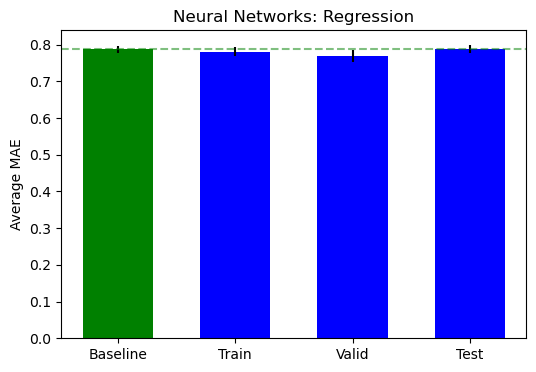

In [27]:
# Retrieve the average MAE and the standard error of the MAE. 
mae = [df_summary_reg['mae_baseline'].mean(), 
       df_summary_reg['mae_train'].mean(), 
       df_summary_reg['mae_valid'].mean(), 
       df_summary_reg['mae_test'].mean()]
mae_se = [np.std(df_summary_reg['mae_baseline']) / np.sqrt(df_summary_reg['mae_baseline'].shape[0]), 
          np.std(df_summary_reg['mae_train']) / np.sqrt(df_summary_reg['mae_train'].shape[0]), 
          np.std(df_summary_reg['mae_valid']) / np.sqrt(df_summary_reg['mae_valid'].shape[0]), 
          np.std(df_summary_reg['mae_test']) / np.sqrt(df_summary_reg['mae_test'].shape[0])]

# Display the average MAE and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), mae, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), mae, yerr = mae_se, fmt = 'None', color = 'black')
axes.axhline(mae[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average MAE')
axes.set_title('Neural Networks: Regression');

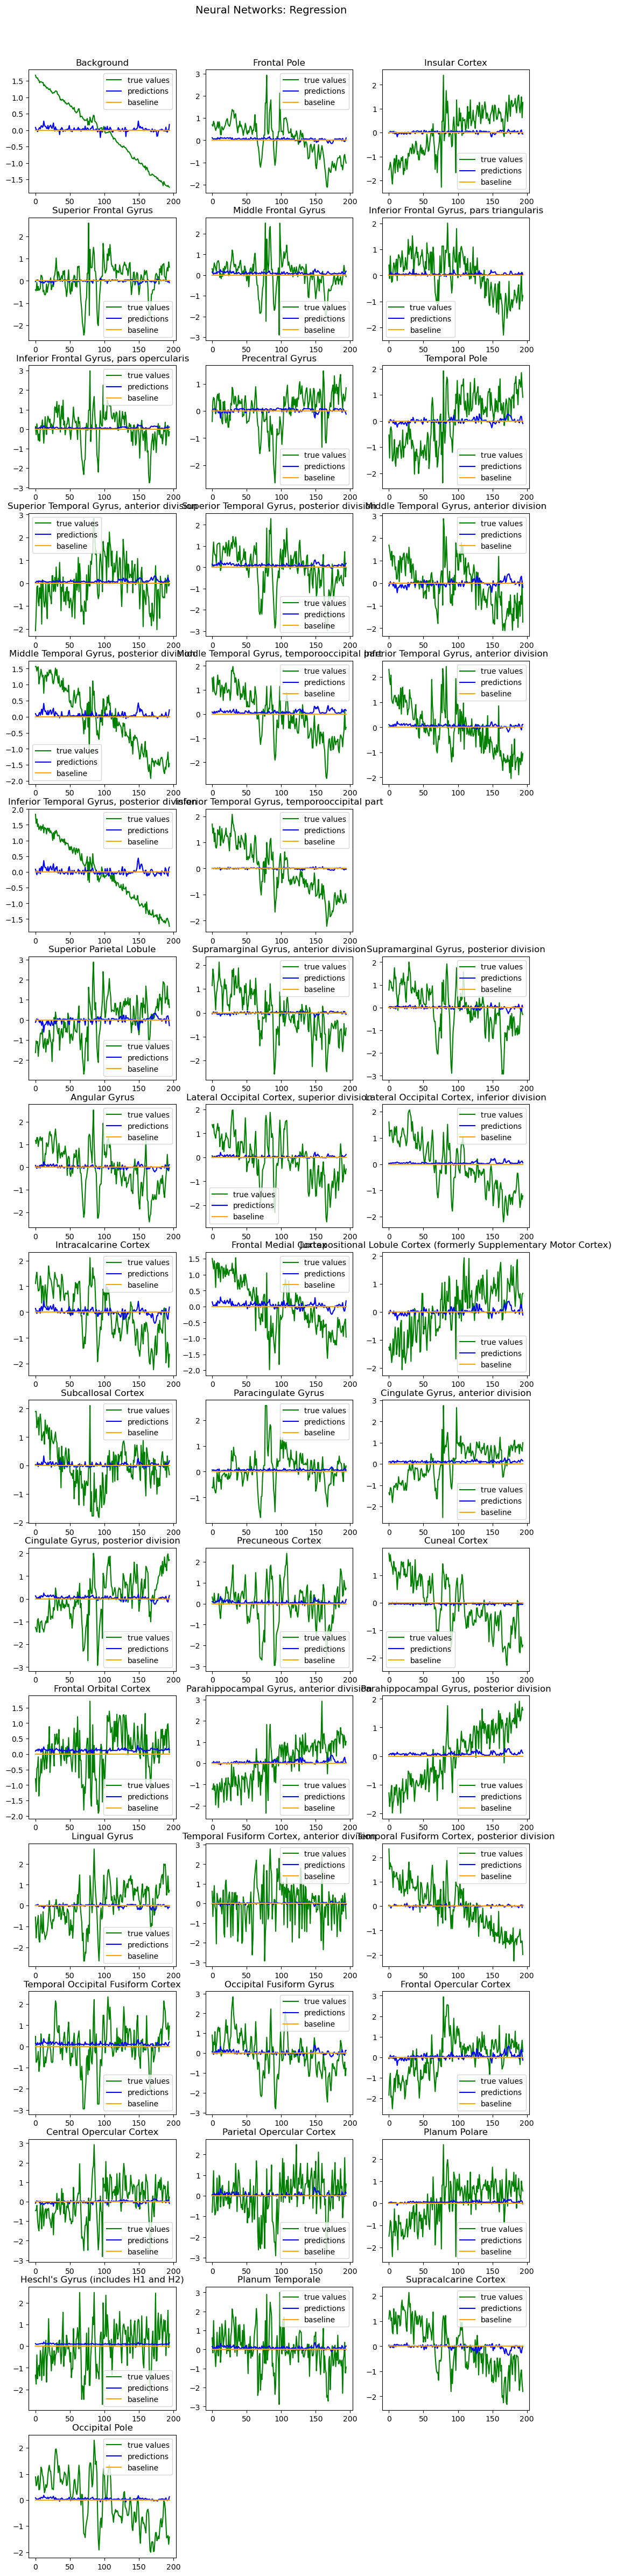

In [28]:
# Select the subject with the best predictions. 
subject = subjects[np.argmax(df_summary_reg['r2_model'])]

# Plot the true values, the predictions, and the baseline for all the targets. 
fig, axes = plt.subplots(nrows = 17, ncols = 3, figsize = (12, 60))
fig.suptitle('Neural Networks: Regression', fontsize = 14, y = 0.9)

# Iterate through all brain regions. 
for brain_region_index in range(len(targets)):

    # Retrieve the true values, the predictions, and the baseline for the selected subject and sequence length. 
    Y_te = dict_targets_sequence_reg[subject]['fmriNF'][:, brain_region_index]
    Y_pred = dict_predictions_reg[subject][:, brain_region_index]
    Baseline = dict_baseline_sequence_reg[subject]['eegfmriNF'][:, brain_region_index]

    # Compute the row and column indexes. 
    row_index = brain_region_index // 3
    column_index = brain_region_index % 3

    # Plot the true values, the predictions, and the baseline. 
    axes[row_index, column_index].plot(Y_te,  color = 'green', label = 'true values')
    axes[row_index, column_index].plot(Y_pred,  color = 'blue', label = 'predictions')
    axes[row_index, column_index].plot(Baseline,  color = 'orange', label = 'baseline')
    axes[row_index, column_index].legend()
    axes[row_index, column_index].set_title(targets[brain_region_index])

# Hide empty subplots. 
axes[5, 2].set_visible(False)
axes[16, 1].set_visible(False)
axes[16, 2].set_visible(False)

## **3. Results**

In [29]:
# Create directories for the results. 
if not os.path.isdir(results_path + 'classification/neural_networks/'):
    os.mkdir(results_path + 'classification/neural_networks/')
if not os.path.isdir(results_path + 'regression/neural_networks/'):
    os.mkdir(results_path + 'regression/neural_networks/')

# Save the models in the native Keras format. 
for subject in subjects:
    dict_models_class[subject].save(results_path + 'classification/neural_networks/' + subject + '.keras')
    dict_models_reg[subject].save(results_path + 'regression/neural_networks/' + subject + '.keras')

# Save the predictions into Pickle files. 
with open(results_path + 'classification/neural_networks/dict_predictions_neural_networks_class.p', 'wb') as file:
    pickle.dump(dict_predictions_class, file)
with open(results_path + 'regression/neural_networks/dict_predictions_neural_networks_reg.p', 'wb') as file:
    pickle.dump(dict_predictions_reg, file)

# Save the summaries into Pickle files. 
with open(results_path + 'classification/neural_networks/df_summary_neural_networks_class.p', 'wb') as file:
    pickle.dump(df_summary_class, file)
with open(results_path + 'regression/neural_networks/df_summary_neural_networks_reg.p', 'wb') as file:
    pickle.dump(df_summary_reg, file)

# Save the FLOPs into a Pickle file. 
with open(results_path + 'flops_neural_networks.p', 'wb') as file:
    pickle.dump(dict_flops, file)